## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('c:/Users/minusca-pol-joc-lo3/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df[df['converted'] == 1].shape[0]/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# First we will use crosstab to see the frequency table of both groups and the landing pages
pd.crosstab(df.group, df.landing_page)

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [7]:
# Then we will sum the inaccurate values which are (treatment group not using new page + control group using new page)
len(df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')]) + len(df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')])

3893

In [8]:
# Or we can use this code 
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [9]:
df.info() # We dont have null values in our dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
# Create the new dataset cleaned from the data of the treatment group who are not using the new page
df2 = df.drop(df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].index)

In [11]:
# Remove the data of the control group who are using the new page
remove_rows = df2[(df2['group'] == 'control') & (df2['landing_page'] == 'new_page')].index
df2.drop(remove_rows, inplace=True)
# Checking our new dataset
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
# Lets find how many duplicates in the user_id
df2.duplicated(['user_id']).sum()

1

In [15]:
# Find which id is reapeated
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [16]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
# We will drop one of the duplicated user_id by index label
df2 = df2.drop(1899)
# Checking 
df2.duplicated(['user_id']).sum()

0

In [18]:
# One more dataset check 
df2.user_id.count()

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
control_mean = df2.query('group == "control"')['converted'].mean()
control_mean

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
treatment_mean = df2.query('group == "treatment"')['converted'].mean()
treatment_mean

0.11880806551510564

In [22]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_mean - control_mean
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [23]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**My answer** 
- No, because the difference in conversion rates between the two groups seems very insufficient to decide .

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{old} - p_{new} \geq 0$$


$$H_1: p_{old} - p_{new} < 0$$
**The threshold of type I errors is $\alpha = 0.05$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [24]:
# Same as the population probability of an individual converting
conv_new = df2['converted'].mean()
conv_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [25]:
# Same as the population probability of an individual converting
conv_old = df2['converted'].mean()
conv_old

0.11959708724499628

c. What is $n_{new}$?

In [26]:
# The treatment group users are shown the new page within our cleaned dataset
n_new = len(df2[df2['landing_page'] == "new_page"])
n_new

145310

d. What is $n_{old}$?

In [27]:
# The control group users are shown the old page within our cleaned dataset
n_old = len(df2[df2['landing_page'] == "old_page"])
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1,0], size=n_new, p=[conv_new, 1-conv_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1,0], size=n_old, p=[conv_old, 1-conv_old])
old_page_converted

array([1, 0, 0, ..., 1, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
# the difference in the converted probability
new_page_converted.mean() - old_page_converted.mean()

-0.0003596623658093656

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [31]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1,0], size=n_new, p=[conv_new, 1-conv_new])
    old_page_converted = np.random.choice([1,0], size=n_old, p=[conv_old, 1-conv_old])
    # append the info
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [32]:
# Convert to numpy array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

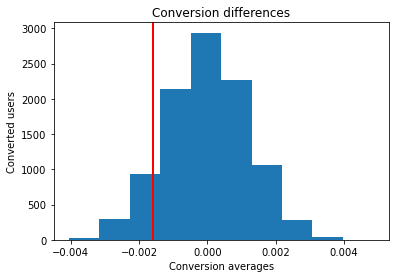

In [33]:
# plot p_diffs distribution
plt.hist(p_diffs);
plt.title('Conversion differences')
plt.xlabel('Conversion averages')
plt.ylabel('Converted users')
# plot line for observed statistic
plt.axvline(obs_diff, color='r', linewidth=2);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
# Compute p-value
(p_diffs > obs_diff).mean()

0.9038

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>**My answer**
- The value we have just computed is called p-value which is the probability of getting our statistic or a more extreme value if the null is true.
- Therefore, small p-value suggest our null is not true, rather our statistic is likely to have come from a different distribution than the null.
- When the p-value is large, we have evidence that our statistic was likely to come from the null hypothesis.
- By comparing our p-value which is (0.90) to our type I error threshold which is (0.05) we can make decision about which hypothesis we choose which is (we fail to reject the null hypothesis). 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

# Number of conversions with the old_page
convert_old = df2[(df2['landing_page']=='old_page')&(df2['converted']==1)].shape[0]
# Number of conversions with the new_page
convert_new = df2[(df2['landing_page']=='new_page')&(df2['converted']==1)].shape[0]
# Number of individuals who were shown the old_page
n_old = len(df2[df2['landing_page'] == "old_page"])
# Number of individuals who received new_page
n_new = len(df2[df2['landing_page'] == "new_page"])

In [36]:
# Showing the numbers of the previous cell
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [37]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**My answer**
- Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error.
- Our hypothesis here is right-tailed test. Accordingly, reject OR fail to reject the null based on the comparison between $Z_{score}$ and $Z_{\alpha}$ or $Z_{0.05}$
- $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests either positive or negative score.
- Our $Z_{score}$ = -1.31 does not exceed the critical value of - 1.645  which confirm the hypothesis we previously choose (**Fail to reject the null hypothesis**).
- Same conclusion here with p-value which is almost identical to the pervious computed p-value.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**My answer**
- We will use **Logistic regression** which predicts categorical response when there are only two possible outcomes.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [38]:
# Add an intercept column 
df2['intercept'] = 1
# Add a (ab_page) column as a dummy variable column, having a value 1 when an individual receives the treatment, otherwise 0.
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
# Check our modifications in the dataset
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [39]:
# Fitting the model
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 03 Feb 2022   Pseudo R-squ.:               8.077e-06
Time:                        15:41:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**My answer**
- The p-value associated with ab_page is (0.19).
- It differs from the p-value found in **Part II** because of the different method we used. In **Part II** we used sampling distribution through 10,000 simulation of conversions rate when the null is true. On the other side in **Part III** Logistic regression which predicts categorical response when there are only two possible outcomes.
- **In part II**:  H0 & H1 are two-sided because we test the difference in conversion rates between the old and new page. 
- **In Part III**  H0 & H1 are one-sided because we only test the coeffecient one predictor the (ab_page) and if it equal to zero or not.
- In our Logistic Regression Model, The p-value = 0.19 > Type I error threshold (0.05) which indicates that we **(Fail to reject the null hypothesis).**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**My answer**
- Cause and effect relationships are difficult to determine. We generally have to control for all other factors to isolate only the change we are interested in to truly determine these types of relationships.
- It can help compare two options, but it can’t tell us about an option we haven’t considered. It can also produce bias results when tested on existing users due to factors like change aversion and novelty effect.
- **Change aversion:** unfair advantage to the old version. 
- **Novelty affect:** unfair advantage to the old version.
- Adding additional terms into our regression model could cause our x-variables to be correlated with one another, this is known as multicollinearity which has two potential negative impacts:
<ol>
    <li>The expected relationships between your x-variables and the response may not hold when multicollinearity is present. That is, you may expect a positive relationship between the explanatory variables and the response (based on the bivariate relationships), but in the multiple linear regression case, it turns out the relationship is negative.</li>
<li>Our hypothesis testing results may not be reliable. It turns out that having correlated explanatory variables means that our coefficient estimates are less stable. That is, standard deviations (often called standard errors) associated with your regression coefficients are quite large. Therefore, a particular variable might be useful for predicting the response, but because of the relationship it has with other x-variables, you will no longer see this association.</li>

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
# Read the countries.csv
countries_df = pd.read_csv('c:/Users/minusca-pol-joc-lo3/countries.csv')
# Join with the df2 dataframe and create a new dataset
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
# Checking our new dataset
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [42]:
# Checking country column unique values 
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [43]:
# Create the necessary dummy variables
df_new[['uk', 'us', 'ca']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,uk,us,ca
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [44]:
# Fit our Linear Model And Obtain the Results
# We will drop (ca) as our baseline  in order to make your matrices full rank
log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'uk', 'us']])
results2 = log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 03 Feb 2022   Pseudo R-squ.:               1.521e-05
Time:                        15:41:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
uk            -0.0408      0.027     -1.518      0.129      -0.093       0.012
us             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [45]:
# Create additional columns of interaction between ab_page and country
df_new['uk_page'] = df_new['uk'] * df_new['ab_page']
df_new['us_page'] = df_new['us'] * df_new['ab_page']
df_new['ca_page'] = df_new['ca'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,uk,us,ca,uk_page,us_page,ca_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0


In [46]:
# Fit our Linear Model And Obtain the Results
log_mod3 = sm.Logit(df_new['converted'], df_new[['intercept', 'uk_page', 'us_page']])
results3 = log_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 03 Feb 2022   Pseudo R-squ.:               2.364e-05
Time:                        15:41:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.08085
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9963      0.006   -322.049      0.000      -2.008      -1.984
uk_page       -0.0752      0.038     -1.997      0.046      -0.149      -0.001
us_page        0.0149      0.017      0.862      0.389      -0.019       0.049
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

**Our Conclusions include both statistical reasoning, and practical reasoning for the situation.**
#### Statistical:
- We tried different types of regressions models and almost all the p-values that we computed were all > (0.05) which indicates that We failed to reject the null hypothesis.
- But when we used an interaction between page and country to see if there are significant effects on conversion, the p-value of uk_page was 0.046 which is < (0.05).
- Although this have significant statistic difference towards the alternative hypothesis and that the new page has enough statically high enough conversion rate in the users from UK but is not sufficient to recommend a decision of launching the new page over the old page. 
- But we will imply that the UK users have more tendency towards novelty that we could use it in future plans if we have more detailed demographic data. Also, the effect of the country factor on any new adjustments.

#### Practical:
- When we do A/B test analyzing we have to consider the practical aspect. Such as, is the new changes expenses profitable in comparison of the return.
- Is lunching the new version or keeping the old version suitable for our different kinds of users like we saw in the pervious parts more UK users converted to the new version. This like the example of one coffee shop presenting one kind of popular coffee but not serving any other variety for attracting new customers’ base.
- We should consider not just the statics but ever possible factor that could affect our outcomes such as timing of lunching , the competition with similar business peers and future plans of expansion …etc. 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.